In [1]:
pip install torch


In [2]:
pip install transformers


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 26.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.7/311.7 kB 25.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 69.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 71.5 MB/s eta 0:00:00


In [12]:
import pandas as pd
import numpy as np
import re
import torch
from transformers import DistilBertModel, DistilBertTokenizer
from sklearn.manifold import TSNE
import plotly.express as px
from sklearn.preprocessing import LabelEncoder

# Load pre-trained DistilBERT model and tokenizer
model = DistilBertModel.from_pretrained('distilbert-base-uncased')
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Load your raw data
df_test = pd.read_excel('/content/report-turbo-8Ido9SdC-v001 (1).xlsx',skiprows=2)  # Replace with the actual path

# Fill missing values in the 'Name', 'Description', and 'Component' columns
df_test[['Description']] = df_test[['Description']].fillna('')

# Columns to focus on
text_columns = ['Name', 'Description']

# Data cleaning function
def clean_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()
    return text

# Apply data cleaning to the specified columns
for col in text_columns:
    df_test[col] = df_test[col].apply(clean_text)

In [17]:
# Function for generating embeddings using DistilBERT
def generate_embeddings_distilbert(texts):
    embeddings = []
    for text in texts:
        inputs = tokenizer(text, return_tensors="pt", truncation=True)
        outputs = model(**inputs)
        embeddings.append(outputs.last_hidden_state.mean(dim=1).squeeze().detach().numpy())
    return np.vstack(embeddings)

In [18]:
# Encode the 'Component' column numerically
label_encoder = LabelEncoder()
df_test['Component'] = label_encoder.fit_transform(df_test['Component'])



In [23]:
# Generate embeddings for 'Name' and 'Description' columns in the test data using DistilBERT
name_embeddings = generate_embeddings_distilbert(df_test['Name'].astype(str))
description_embeddings = generate_embeddings_distilbert(df_test['Description'].astype(str))

# Create new columns for embeddings
df_test['Name_embedding'] = name_embeddings.tolist()
df_test['Description_embedding'] = description_embeddings.tolist()

In [24]:
# Perform T-SNE for dimensionality reduction on the test data
tsne_test = TSNE(n_components=2, random_state=42)
df_test_2d = pd.DataFrame(tsne_test.fit_transform(np.stack(df_test['Name_embedding'])),
                          columns=['TSNE1', 'TSNE2'])
df_test_2d['Component'] = df_test['Component']

# Plot 2D representation for the test data
fig_test = px.scatter(df_test_2d, x='TSNE1', y='TSNE2', color='Component', title='Test Split')

# Display the plot
fig_test.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



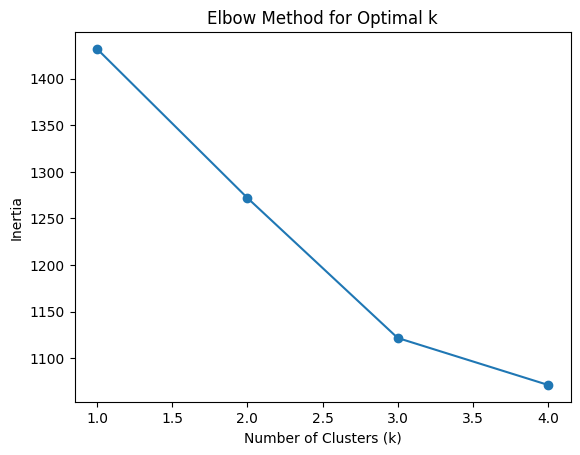

In [29]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt


# Combine the embeddings for k-Means clustering
combined_embeddings = np.concatenate([name_embeddings, description_embeddings], axis=1)

# Find the optimal number of clusters using the elbow method
inertia = []
for n_clusters in range(1, 5):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(combined_embeddings)
    inertia.append(kmeans.inertia_)

# Plot the elbow method graph
plt.plot(range(1, 5), inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.show()

In [40]:
# Combine the T-SNE components for k-Means clustering
combined_embeddings = df_test_2d[['TSNE1', 'TSNE2']].values

# Apply k-Means clustering
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df_test_2d['Cluster'] = kmeans.fit_predict(combined_embeddings)

# Plot 2D representation for the test data with color-coded clusters
fig_test_clusters = px.scatter(df_test_2d, x='TSNE1', y='TSNE2', color='Cluster',
                               title=f'K-Means Clustering Results for Test Split (k={optimal_k})')
fig_test_clusters.show()


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [63]:
def Transformation(transform_df, Type):
    # Load pre-trained DistilBERT model and tokenizer
    model = DistilBertModel.from_pretrained('distilbert-base-uncased')
    tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

    # Fill missing values in the 'Name', 'Description', and 'Component' columns
    transform_df[['Description']] = transform_df[['Description']].fillna('')

    # Columns to focus on
    text_columns = ['Name', 'Description']

    # Data cleaning function
    def clean_text(text):
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        text = text.lower()
        return text

    # Apply data cleaning to the specified columns
    for col in text_columns:
        transform_df[col] = transform_df[col].apply(clean_text)

    # Function for generating embeddings using DistilBERT
    def generate_embeddings_distilbert(texts):
        embeddings = []
        for text in texts:
            inputs = tokenizer(text, return_tensors="pt", truncation=True)
            outputs = model(**inputs)
            embeddings.append(outputs.last_hidden_state.mean(dim=1).squeeze().detach().numpy())
        return np.vstack(embeddings)

    # Encode the 'Component' column numerically
    label_encoder = LabelEncoder()
    transform_df['Component'] = label_encoder.fit_transform(transform_df['Component'])

    # Generate embeddings for 'Name' and 'Description' columns in the test data using DistilBERT
    name_embeddings = generate_embeddings_distilbert(transform_df['Name'].astype(str))
    description_embeddings = generate_embeddings_distilbert(transform_df['Description'].astype(str))

    # Create new columns for embeddings
    transform_df['Name_embedding'] = name_embeddings.tolist()
    transform_df['Description_embedding'] = description_embeddings.tolist()

    # Perform T-SNE for dimensionality reduction on the test data
    tsne_test = TSNE(n_components=2, random_state=42)
    transform_df_2d = pd.DataFrame(tsne_test.fit_transform(np.stack(transform_df['Name_embedding'])),
                              columns=['TSNE1', 'TSNE2'])
    transform_df_2d['Component'] = transform_df['Component']

    # Plot 2D representation for the test data
    fig_test = px.scatter(transform_df_2d, x='TSNE1', y='TSNE2', color='Component', title= Type +' Split')

    # Display the plot
    fig_test.show()


    # Combine the embeddings for k-Means clustering
    combined_embeddings = np.concatenate([name_embeddings, description_embeddings], axis=1)

    # Find the optimal number of clusters using the elbow method
    inertia = []
    for n_clusters in range(1, 5):
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        kmeans.fit(combined_embeddings)
        inertia.append(kmeans.inertia_)

    # Plot the elbow method graph
    plt.plot(range(1, 5), inertia, marker='o')
    plt.title('Elbow Method for Optimal k')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Inertia')
    plt.show()


    # Combine the T-SNE components for k-Means clustering
    combined_embeddings = transform_df_2d[['TSNE1', 'TSNE2']].values

    # Apply k-Means clustering
    kmeans = KMeans(n_clusters=optimal_k, random_state=42)
    transform_df_2d['Cluster'] = kmeans.fit_predict(combined_embeddings)

    # Plot 2D representation for the test data with color-coded clusters
    fig_test_clusters = px.scatter(transform_df_2d, x='TSNE1', y='TSNE2', color='Cluster',
                                  title=f'K-Means Clustering Results for '+ Type + 'Split (k={optimal_k})')
    fig_test_clusters.show()


## Clustering on Test data

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



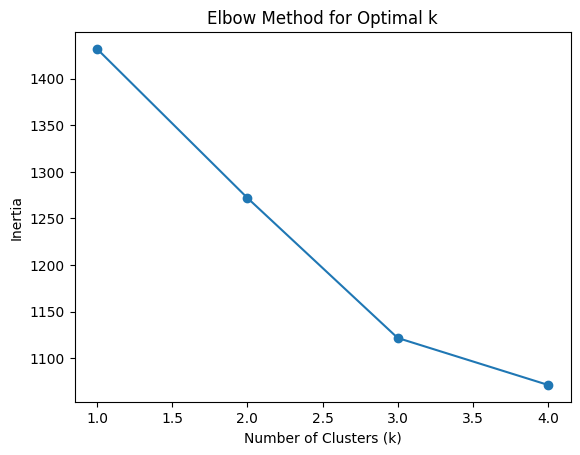

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [64]:
df_test = pd.read_excel('/content/report-turbo-8Ido9SdC-v001 (1).xlsx',skiprows=2)
Transformation(df_test, 'Test')




---



---


---



---



# Clustering on Mock data

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



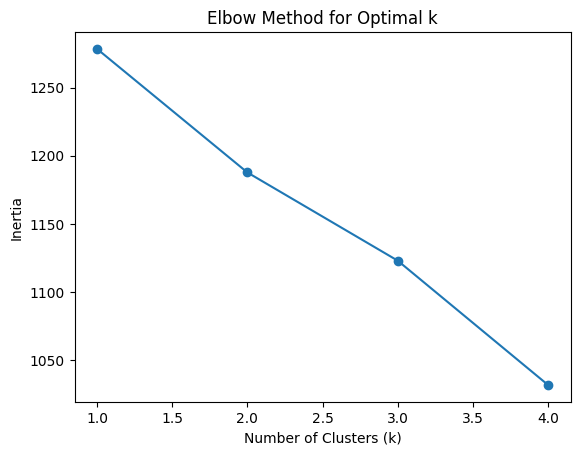

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [65]:
df_mock = pd.read_excel('/content/Mock100 1.xlsx')
Transformation(df_mock, 'Mock')



---



---



---



---

#Clustering on Train data

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



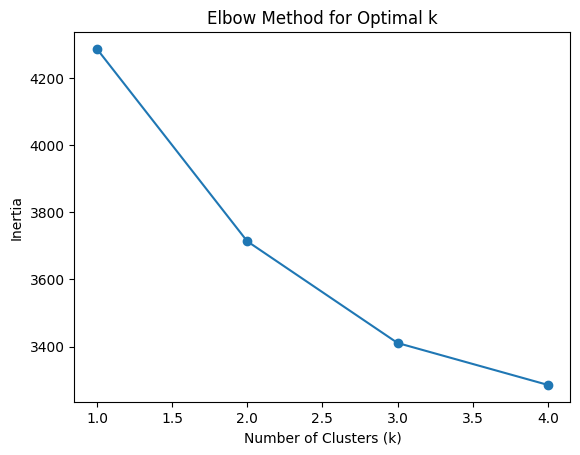

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [66]:
df_train = pd.read_excel('/content/train.xlsx')
Transformation(df_train, 'Train')